# Book rating regression project

## Loading the dataset

In [1]:
import pandas as pd

In [3]:
raw_df = pd.read_csv(
    filepath_or_buffer="/Users/attoumassa/DSTI/Python Labs/Project/books.csv",
    on_bad_lines="warn",
    sep=",",
    skipinitialspace=True,
)

b'Skipping line 3350: expected 12 fields, saw 13\nSkipping line 4704: expected 12 fields, saw 13\nSkipping line 5879: expected 12 fields, saw 13\nSkipping line 8981: expected 12 fields, saw 13\n'


We notice how some rows had too many fields. The `on_bad_lines="warn"` argument skips them for us. When we go look at those rows in the csv file, we notice that some books had comas `,` in their title or authors names.
For example for line 3350 is as follows:
`12224,Streetcar Suburbs: The Process of Growth in Boston  1870-1900,Sam Bass Warner, Jr./Sam B. Warner,3.58,0674842111,9780674842113,en-US,236,61,6,4/20/2004,Harvard University Press`
The author name is contains a coma `Sam Bass Warner, Jr./Sam B. Warner`.

We will skip those lines for now.

In [4]:
raw_df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


Checking for NA values:

In [5]:
raw_df.isna().sum()

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
num_pages             0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64

Great, we have no NA values. The dataset is now clean

In [6]:
df = raw_df

In [7]:
df.describe()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11123.000000,11123.000000,1.112300e+04,11123.000000,1.112300e+04,11123.000000
mean,21310.856963,3.934075,9.759880e+12,336.405556,1.794285e+04,542.048099
std,13094.727252,0.350485,4.429758e+11,241.152626,1.124992e+05,2576.619589
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,10277.500000,3.770000,9.780345e+12,192.000000,1.040000e+02,9.000000
50%,20287.000000,3.960000,9.780582e+12,299.000000,7.450000e+02,47.000000
75%,32104.500000,4.140000,9.780872e+12,416.000000,5.000500e+03,238.000000
max,45641.000000,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000


## Preliminary analysis

**Questions:**
- Is the data balanced?
- Which features are useful and which aren't?

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

We will plot the distributions of the main numerical features:
- number of pages
- number of ratings
- number of reviews
- average rating

In [112]:
def count_page(): 
    c=0
    l=df["title"]
    for x in df["ratings_count"]:
        if x==6:
            #l=df["title"]
            c= c+1
    print(c)

In [113]:
count_page()

57


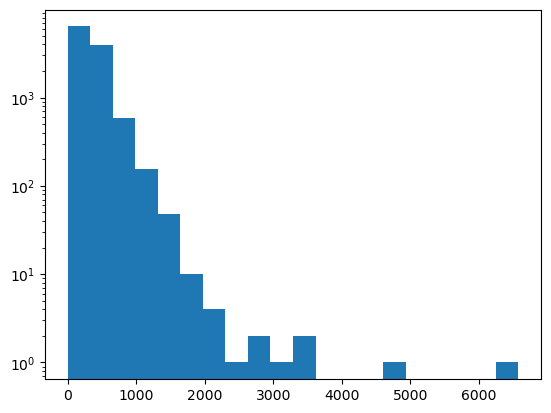

In [60]:
#plt.figure(figsize=(20,20))
plt.hist(df["num_pages"], bins=20)
plt.yscale("log")

plt.show()

- On remarque que plus de **90%** de notre dataset ont un nombre de pages inférieur ou égale à 600 soit 10053 livres/11123 

- We notice that more than *90%* of our dataset 

In [79]:
import seaborn as sns

<AxesSubplot:xlabel='average_rating', ylabel='num_pages'>

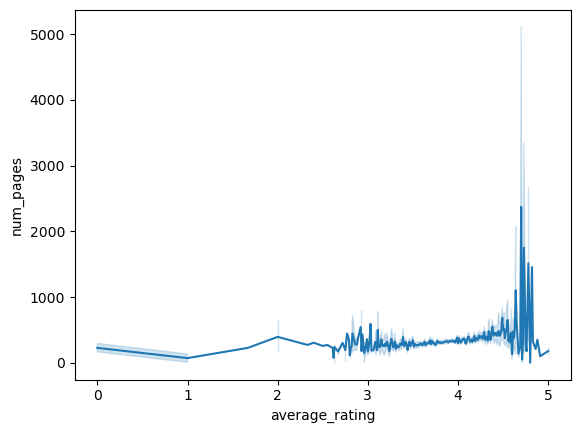

In [81]:
sns.lineplot(data=df,x="average_rating",y="num_pages")

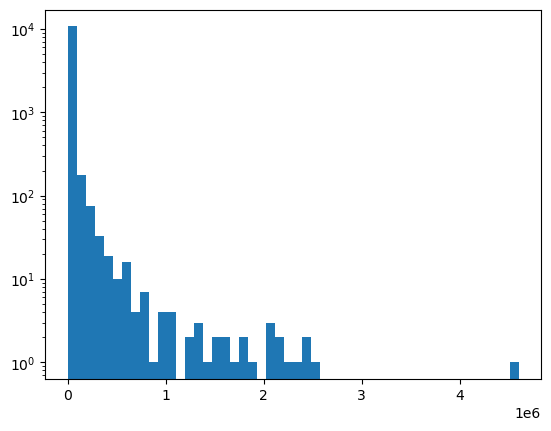

In [98]:
plt.hist(df["ratings_count"], bins=50)
plt.yscale("log")
plt.show()

<AxesSubplot:xlabel='ratings_count', ylabel='bookID'>

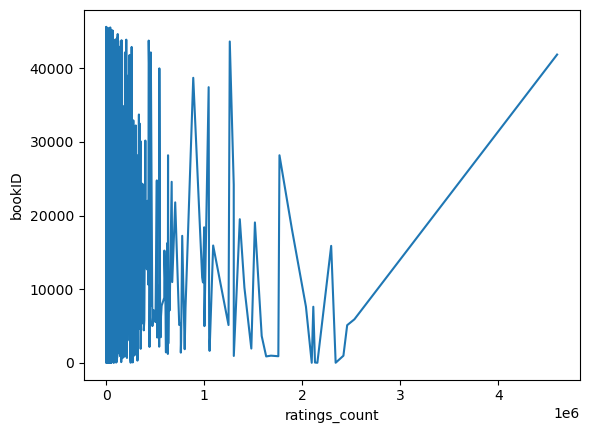

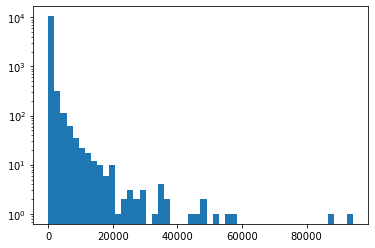

In [291]:
plt.hist(df["text_reviews_count"], bins=50)
plt.yscale("log")
plt.show()

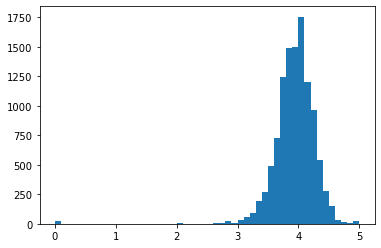

In [292]:
plt.hist(df["average_rating"], bins=50)
plt.show()

We notice immediately that the target feature `average_rating` is skewed towards an average of 4. It resembles a normal distribution.
We will have to take this into consideration when creating the training and testing sets: these sets should both include books with a wide range of average ratings.

In [293]:
corr_matrix = df.corr(numeric_only=True)

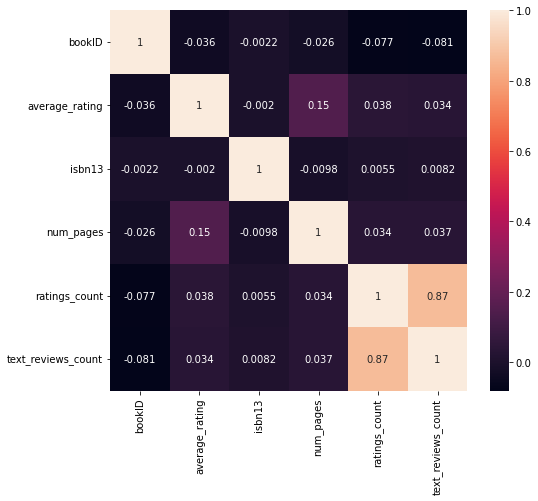

In [294]:
plt.figure(figsize=(8, 7))
sns.heatmap(corr_matrix, annot=True)
plt.show()

We are particularly interested in the correlations between `average_rating` and other features. We make a few observations:
- `average_rating` has no substantial correlation with `isnb13` which should be expected
- `average_rating` slighty correlates with `ratings_count` and `text_reviews_count`. Meaning that on average, books with more ratings and reviews tend to have slightly better ratings
- `average_rating` correlates positively with `num_pages` in decent amounts
- `average_rating` slighty correlates negatively with `bookID`. This has no reason to be the case and is likely just noise from the random ordering of the dataset.

In the next section, we will try to see if the age of the book could be an interesting feature. In particular, does the age of the book have an impact on the average rating ?

In [295]:
from datetime import datetime, MINYEAR, timedelta
from time import strptime

In [296]:
def date_to_datetime(date):
    try:
        new_time_format = datetime.strptime(date, "%m/%d/%Y")
        return new_time_format
    except ValueError:
        newdate = date.split("/")
        if newdate[1] == "31":
            newdate[1] = "30"
        newdate = newdate[0] + "/" + newdate[1] + "/" + newdate[2]
        return datetime.strptime(newdate, "%m/%d/%Y")

In [297]:
df["publication_date"] = df["publication_date"].apply(date_to_datetime)

In [298]:
oldest_book = min(df["publication_date"])
newest_book = max(df["publication_date"])

In [317]:
def normalise_age(book_date):
    return (book_date.timestamp() - oldest_book.timestamp()) / (newest_book.timestamp() - oldest_book.timestamp())


In [325]:
df["normalised_age"] = df["publication_date"].apply(normalise_age)



We have created a feature which describes the age of the book where 0 is the oldest book in the dataset (Consider the Lilies) and 1 is the most recent book (A Quick Bite (Argeneau #1))
Let's look the distribution of book age and how this feature correlates with the average_rating

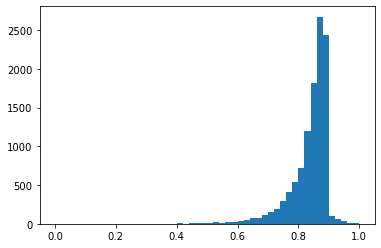

In [331]:
plt.hist(df["normalised_age"], bins=50)
plt.show()

We see that the age distribution isn't balanced. most books from the dataset have been published in the second half of the 20th century.

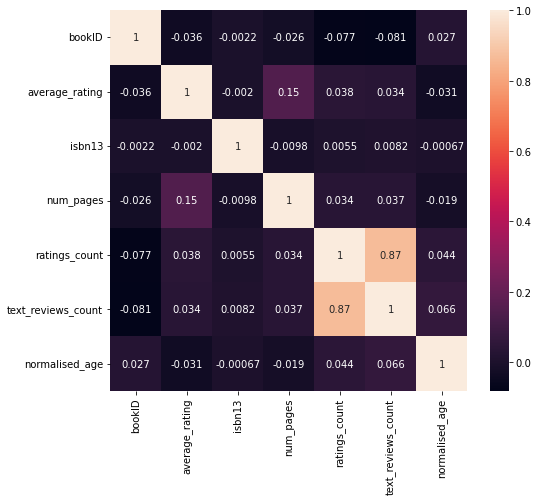

In [328]:
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(8, 7))
sns.heatmap(corr_matrix, annot=True)
plt.show()

The `normalised_age` slightly anticorrelates with the average rating. This means that on average, older books have slightly better ratings than more modern books.